In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import re
import os
from pathlib import Path
import jieba
import nltk
import gensim
from gensim.utils import tokenize, simple_preprocess
import wordcloud

### todo:
1. 各招聘平台含性别优先字样的广告百分比
2. 男性优先招聘广告数前十的行业 和 女性优先招聘广告数前十的行业。相同行业针对性别放出的岗位是否不同
3. analyze discrimination words for two genders.
4. analyze salary difference between genders

In [2]:
import matplotlib
matplotlib.rc('font', family='Heiti TC') # enable to display chinese characters

In [3]:
co = matplotlib.cm.get_cmap('tab20')
male_color = matplotlib.colors.rgb2hex(co(0))
female_color = matplotlib.colors.rgb2hex(co.reversed()(0))

In [4]:
# read pd from pickle files

In [5]:
from pathlib import Path
BASE_DIR = Path(".").resolve().parents[0]
DATA_DIR = BASE_DIR.joinpath("data")

In [6]:
with open(DATA_DIR.joinpath("liepin_female.pickle"), "rb") as f:
    liepin_f_df = pickle.load(f)
with open(DATA_DIR.joinpath("liepin_male.pickle"), "rb") as f:
    liepin_m_df = pickle.load(f)
with open(DATA_DIR.joinpath("wuyi_female.pickle"), "rb") as f:
    wuyi_f_df = pickle.load(f)
with open(DATA_DIR.joinpath("wuyi_male.pickle"), "rb") as f:
    wuyi_m_df = pickle.load(f)
with open(DATA_DIR.joinpath("zhuobo_female.pickle"), "rb") as f:
    zhuobo_f_df = pickle.load(f)
with open(DATA_DIR.joinpath("zhuobo_male.pickle"), "rb") as f:
    zhuobo_m_df = pickle.load(f)

In [8]:
liepin_f_df = liepin_f_df.drop_duplicates(subset=["company_name","descrimination_content", "job_title"], ignore_index=True)
liepin_m_df = liepin_m_df.drop_duplicates(subset=["company_name","descrimination_content", "job_title"], ignore_index=True)
wuyi_f_df = wuyi_f_df.drop_duplicates(subset=["company_name","descrimination_content", "job_title"], ignore_index=True)
wuyi_m_df = wuyi_m_df.drop_duplicates(subset=["company_name","descrimination_content", "job_title"], ignore_index=True)
zhuobo_f_df = zhuobo_f_df.drop_duplicates(subset=["company_name","descrimination_content", "job_title"], ignore_index=True)
zhuobo_m_df = zhuobo_m_df.drop_duplicates(subset=["company_name","descrimination_content", "job_title"], ignore_index=True)



In [9]:
count_list = [{'female_count': len(liepin_f_df), 'male_count': len(liepin_m_df), 'platform': '猎聘'},
              {'female_count': len(wuyi_f_df), 'male_count': len(wuyi_m_df), 'platform': '前程无忧'},
              {'female_count': len(zhuobo_f_df), 'male_count': len(zhuobo_m_df), 'platform': '卓博'},
             ]
count_df = pd.DataFrame(count_list)
count_df = count_df.set_index('platform')


In [10]:
count_df

,female_count,male_count
platform,,
猎聘,44,87
前程无忧,72,19
卓博,47,47


In [11]:
def platform_overview_bar_chart(count_df):
    """
    :param count_df: pandas dataframe, platform as index, with two columns: "female_count" and "male_count"
    representing the number of records
    """
    perc_count_df = count_df.apply(lambda x: x*100/sum(x), axis=1)
    title = "各招聘平台含性别优先字样的广告百分比"
    ax = perc_count_df.plot(
        kind='bar', stacked=True, ylabel="百分比", xlabel='',
        colormap='tab20',
    )
    plt.xticks(rotation=0)
    plt.legend(bbox_to_anchor=(1.05, 1), frameon=False, labels=['男性优先', '女性优先'])
    ax.set(frame_on=False) 
    ax.set_title(title, pad=25)
    # tODO: display text in bar?


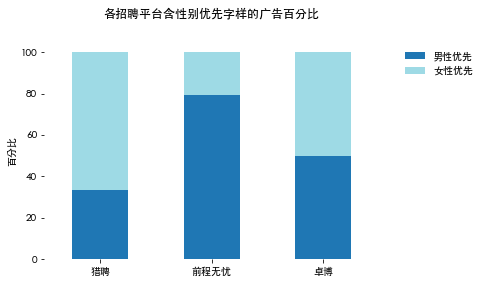

In [12]:
platform_overview_bar_chart(count_df)

In [13]:
# prepare two dataframe and remove duplicated records based on contents from three columns
f_df = pd.concat([liepin_f_df,wuyi_f_df, zhuobo_f_df], ignore_index=True)
m_df = pd.concat([liepin_m_df,wuyi_m_df, zhuobo_m_df],ignore_index=True)

f_df = f_df.drop_duplicates(subset=["company_name","descrimination_content", "job_title"], ignore_index=True)
m_df = m_df.drop_duplicates(subset=["company_name","descrimination_content", "job_title"], ignore_index=True)

In [16]:
columns = ['company_industry', 'platform']
cp_industry_female = f_df[columns]
cp_industry_male = m_df[columns]

In [203]:
cp_industry_female['company_industry'].value_counts(dropna=False).head(10)/len(cp_industry_female['company_industry'])

NaN      0.150838
电子技术     0.134078
计算机软件    0.100559
专业服务     0.100559
贸易       0.072626
其他生产     0.050279
机械制造     0.039106
百货       0.033520
汽车       0.033520
橡胶       0.033520
Name: company_industry, dtype: float64

In [303]:
cp_industry_female['company_industry'].value_counts(dropna=False)/len(cp_industry_female['company_industry'])*100
                                                                             
                                                                             

NaN          15.083799
电子技术         13.407821
计算机软件        10.055866
专业服务         10.055866
贸易            7.262570
其他生产          5.027933
机械制造          3.910615
百货            3.351955
汽车            3.351955
橡胶            3.351955
原材料及加工        1.675978
办公用品及设备       1.675978
建筑            1.675978
印刷            1.117318
通信            1.117318
计算机服务         1.117318
教育            1.117318
金属制品          1.117318
互联网           1.117318
原材料和加工        0.558659
计算机硬件         0.558659
工艺品           0.558659
多元化业务集团公司     0.558659
基金            0.558659
仪器仪表          0.558659
医疗设备          0.558659
快速消费品         0.558659
咨询            0.558659
纺织品业(服饰       0.558659
中介服务          0.558659
餐饮业           0.558659
建筑施工与工程       0.558659
房地产开发         0.558659
电子商务          0.558659
能源            0.558659
批发            0.558659
新能源           0.558659
环保            0.558659
租赁服务          0.558659
金融            0.558659
通讯            0.558659
游戏产业          0.558659
交通            0.558659
Name: compa

In [234]:
f_pct.rename(index={np.nan: "无"})

无         39.102564
电子技术       8.333333
人力资源服务     4.487179
互联网        3.846154
机械制造       3.846154
专业服务       3.205128
咨询         3.205128
百货         1.923077
其他生产       1.923077
其他         1.923077
Name: company_industry, dtype: float64

In [17]:
def company_industry_count_comparison(df, color, title):
    pct_series = round(df['company_industry'].value_counts(dropna=False).head(10)/len(df['company_industry'])*100)
    pct_series.rename(index={np.nan: "无"}, inplace=True)
    ax=pct_series.sort_values().plot(kind='barh', color=color)
    ax.set(frame_on=False,xlim=(0,50), xlabel="百分比")
    ax.set_title(title, pad=25)
    

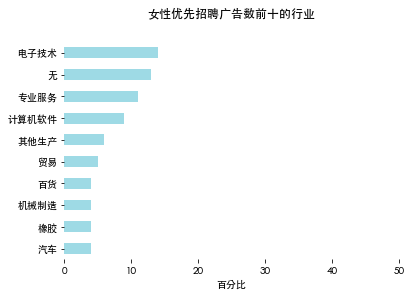

In [18]:
company_industry_count_comparison(f_df, female_color, "女性优先招聘广告数前十的行业")

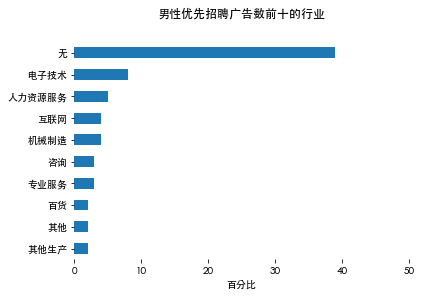

In [19]:
company_industry_count_comparison(m_df, male_color, "男性优先招聘广告数前十的行业")

#### Q: what happens to 电子技术
发布女性优先的电子技术类公司主要招收普通女临时工， 而发布男性优先的电子技术类公司的职业类型比较多样，有计划员，销售代表，学徒，助理工程师等


In [294]:
# what happens to 电子技术
f_df.loc[f_df['company_industry']=='电子技术',['company_industry', 'company_type', 'job_type', 'job_title']]

,company_industry,company_type,job_type,job_title
55,电子技术,民营公司,普工,普工操作工技术工装配质检员CNC临时工小时工正式工7k
56,电子技术,民营公司,普工,普工操作工组装工包装工正式工临时工小时工服务员月7K
59,电子技术,民营公司,组装工,普工组装工包装工正式工临时工小时工6K包吃住新人奖3K
67,电子技术,民营公司,包装工,汽配组装+长白班+包吃住
68,电子技术,民营公司,组装工,美术厂打包长白班包吃住18元/时
83,电子技术,民营公司,组装工,直招普工临时工操作工组装工无需经验全坐班月入7千
84,电子技术,民营公司,普工,200块一天直招普工操作工包装工组装工
86,电子技术,民营公司,普工,新产线订单猛增7200普工临时工小时工组装工分拣员
87,电子技术,民营公司,普工,普工暑假工+长白班+包吃住+6k起
88,电子技术,民营公司,普工,直招普工操作工临时工长白班7k


In [295]:
m_df.loc[m_df['company_industry']=='电子技术',['company_industry', 'company_type', 'job_type', 'job_title']]

,company_industry,company_type,job_type,job_title
72,电子技术,NaN,NaN,电气设计工程师
92,电子技术,上市公司,生产计划,生管员/计划员
97,电子技术,民营公司,销售代表,销售代表
110,电子技术,NaN,文案策划,副总经理助理
112,电子技术,NaN,采购专员,采购员
119,电子技术,NaN,电子工程师,助理工程师
124,电子技术,NaN,质量管理,总经理助理
127,电子技术,NaN,税务专员,税务会计兼出纳
128,电子技术,NaN,模切机机长,模切学徒
129,电子技术,NaN,采购管理员,采购员


同为电子技术行业，招聘的职位对于不同性别而言确实大为不同   
详见最后分析

#### Q: what happened to 机械制造
虽然同为机械制造行业，要求男性优先的职位看起来比要求女性优先的职位高级    
TODO：compare the job description, and see if any particular requriments that only man/women can do the job

In [296]:
# what happened to 机械制造
f_df.loc[f_df['company_industry']=='机械制造',['company_industry', 'company_type', 'job_type', 'job_title']]

,company_industry,company_type,job_type,job_title
133,机械制造,NaN,机械,电工
150,机械制造,NaN,业务跟单员,业务跟单
152,机械制造,NaN,国内贸易人员,业务跟单
162,机械制造,NaN,普通工人,接线员
163,机械制造,NaN,业务员,模具外贸业务员
177,机械制造,NaN,网店,淘宝客服
178,机械制造,NaN,质量管理,OQC品检员


In [297]:
m_df.loc[m_df['company_industry']=='机械制造',['company_industry', 'company_type', 'job_type', 'job_title']]

,company_industry,company_type,job_type,job_title
0,机械制造,NaN,NaN,业务工程师（日语）
109,机械制造,NaN,仓库管理员,仓库管理员
137,机械制造,NaN,市场,项目推广经理
144,机械制造,NaN,人事专员,人资专员
151,机械制造,NaN,文员,生产文员
153,机械制造,NaN,储备干部,中专实习生储备干部


#### Q: for 互联网行业
要求女性优先的互联网招聘工作数量并没有排进前十, 不过不论男性优先还是女性优先的职位大都是销售推广客服方向

In [304]:
m_df.loc[m_df['company_industry']=='互联网',['company_industry', 'company_type', 'job_type', 'job_title']]

,company_industry,company_type,job_type,job_title
3,互联网,NaN,NaN,投资管理(成都运达科技股份有限公司)
24,互联网,NaN,NaN,推广专员
44,互联网,NaN,NaN,跨境电商运营助理
100,互联网,民营公司,电商运营,阿里巴巴 销售 客服 运营 1688 业务员
106,互联网,民营公司,软件测试工程师,软件测试工程师
107,互联网,民营公司,摄影师,实习生（摄像/后期制作方向）


In [305]:
f_df.loc[f_df['company_industry']=='互联网',['company_industry', 'company_type', 'job_type', 'job_title']]

,company_industry,company_type,job_type,job_title
79,互联网,民营公司,网店客服,急招淘宝天猫客服销售，包吃住
92,互联网,民营公司,活动策划,活动策划执行


In [ ]:
#### Q: 专业服务


In [306]:
f_df.loc[f_df['company_industry']=='专业服务',['company_industry', 'company_type', 'job_type', 'job_title']]

,company_industry,company_type,job_type,job_title
0,专业服务,NaN,NaN,人力资源总监
17,专业服务,NaN,NaN,招生助理
18,专业服务,NaN,NaN,新媒体运营
22,专业服务,NaN,NaN,经纪人
23,专业服务,NaN,NaN,艺人经纪人
32,专业服务,NaN,NaN,高薪诚聘人事招聘专员
33,专业服务,NaN,NaN,行政助理
34,专业服务,NaN,NaN,助理/秘书/文员
40,专业服务,NaN,NaN,赴日各大机场免税店翻译导购人员
64,专业服务,民营公司,普工,辉烨通讯


In [307]:
m_df.loc[m_df['company_industry']=='专业服务',['company_industry', 'company_type', 'job_type', 'job_title']]

,company_industry,company_type,job_type,job_title
9,专业服务,NaN,NaN,总经理
23,专业服务,NaN,NaN,电话销售
51,专业服务,NaN,NaN,英语翻译
52,专业服务,NaN,NaN,行政助理/办公室助理
89,专业服务,民营公司,销售代表,销售经理


#### Q： 计算机软件
没有想到计算机软件行业要求女性优先的招聘广告占比高于男性优先, 但深究之后发现那些女性优先的岗位大多数都是工厂的普通临时工，和电子技术类行业类似

In [308]:
m_df.loc[m_df['company_industry']=='计算机软件',['company_industry', 'company_type', 'job_type', 'job_title']]

,company_industry,company_type,job_type,job_title
99,计算机软件,民营公司,销售代表,销售专员
102,计算机软件,上市公司,其他,数据录入岗


In [309]:
f_df.loc[f_df['company_industry']=='计算机软件',['company_industry', 'company_type', 'job_type', 'job_title']]

,company_industry,company_type,job_type,job_title
19,计算机软件,NaN,NaN,短视频编导
27,计算机软件,NaN,NaN,客服专员
52,计算机软件,民营公司,ERP实施顾问,实习生-实施实习生
57,计算机软件,民营公司,普工,7千+普工暑假工操作工组装工包装工正式工临时工小时工
58,计算机软件,民营公司,普工,普工操作工组装工包装工临时工小时工正式工QC包吃住6K
60,计算机软件,民营公司,普工,暑假工普工组装工包装工实习生正式工临时工小时工6千+
61,计算机软件,民营公司,普工,7千+普工操作工组装工包装工临时工小时工正式工实习生
72,计算机软件,民营公司,UI设计师,UI设计师（急聘）
96,计算机软件,民营公司,普工,长白班7000普工临时工操作工组装工包装工学徒分拣员
102,计算机软件,民营公司,普工,普工操作工组装工包装工临时工小时工正式工QC包吃住6K


#### Q： 其他生产


In [310]:
f_df.loc[f_df['company_industry']=='其他生产',['company_industry', 'company_type', 'job_type', 'job_title']]

,company_industry,company_type,job_type,job_title
135,其他生产,NaN,业务员,业务员
141,其他生产,NaN,生产经理,跟单组长
142,其他生产,NaN,商务助理,女外贸业务员
145,其他生产,NaN,业务员,业务跟单
147,其他生产,NaN,业务员,外贸业务
154,其他生产,NaN,质量管理,品管
159,其他生产,NaN,品管员,品管员
167,其他生产,NaN,公司文职类,生产文员
168,其他生产,NaN,售前,国际售后工程师


In [311]:
m_df.loc[m_df['company_industry']=='其他生产',['company_industry', 'company_type', 'job_type', 'job_title']]

,company_industry,company_type,job_type,job_title
115,其他生产,NaN,生产管理,助理工程师
122,其他生产,NaN,项目经理,项目经理
138,其他生产,NaN,生产管理,采购员


############################### ##########################

Cant find top 10 job title for two genders, because titles are usually unique. => consider using nlp package to cluster similar job titles.

In [313]:
round(f_df['job_title'].value_counts(dropna=False).head(10)/len(f_df['job_title'])*100)



行政专员                           3.0
亚马逊运营专员                        3.0
业务跟单                           2.0
普工操作工组装工包装工临时工小时工正式工QC包吃住6K    2.0
总经理秘书                          2.0
销售管理培训生（凤凰卫视打造高端项目）            1.0
品管                             1.0
文员                             1.0
7千+普工暑假工打包员实习生包装工正式工临时工小时工     1.0
客服专员                           1.0
Name: job_title, dtype: float64

In [324]:
print("total", len(f_df['job_title']))
print("unique", len(f_df['job_title'].unique()))

total 163
unique 149


In [325]:
print("total", len(m_df['job_title']))
print("unique", len(m_df['job_title'].unique()))

total 153
unique 142


#### Q: what about compnay_industry == None? which is the largest portion of the data collected
=> cant tell too much, need to tokenize the job title and see what can be found

In [326]:
f_df.loc[f_df['company_industry'].isnull(),['company_industry', 'company_type', 'job_type', 'job_title']].head()

,company_industry,company_type,job_type,job_title
1,None,NaN,NaN,行政专员
2,None,NaN,NaN,行政专员
3,None,NaN,NaN,电商设计师
4,None,NaN,NaN,广告投放负责人
5,None,NaN,NaN,活动运营


In [327]:
m_df.loc[m_df['company_industry'].isnull(),['company_industry', 'company_type', 'job_type', 'job_title']].head()

,company_industry,company_type,job_type,job_title
1,None,NaN,NaN,财务副经理
2,None,NaN,NaN,零售经理
4,None,NaN,NaN,日语客户质量工程师（CQ/CS）
5,None,NaN,NaN,高级项目经理
6,None,NaN,NaN,装卸工人


#### analyze discrimination words for two genders

In [12]:
import jieba
import nltk
import gensim
from gensim.utils import tokenize, simple_preprocess

In [28]:
# load customzied tokenizer words to facilitate cutting
jieba.load_userdict("./user_dict.txt")

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/bq/v3wvjpdj50b6ws61sp6ml0gr0000gp/T/jieba.cache
Loading model cost 0.727 seconds.
Prefix dict has been built successfully.


In [49]:
user_stop_words = set()
with open("./user_stopwords.txt", 'r') as f:
    user_stop_words = set(f.read().splitlines()) 


In [50]:
def process_descrimination_contents(df, user_stop_words):
    """
    # param: df: pandas data frame, containing column "descrimination_content"
    # param: stop_words: set of customized stop words
    
    # return: [[str]] list of list of tokenized words
    """
    res = []
    for item in df['descrimination_content']:
        phrase = gensim.utils.tokenize(item) # return a generator， remove number and special characters
        temp = []
        for p in phrase:
            words = jieba.lcut(p)
            temp.extend([w for w in words if len(w)>1 and w not in user_stop_words])
        if temp:
            res.append(temp) 
    return res

In [51]:
f_des_res = process_descrimination_contents(f_df, user_stop_words)

In [52]:
f_des_texts = sum(f_des_res, [])

In [53]:
m_des_res = process_descrimination_contents(m_df, user_stop_words)

In [54]:
m_des_texts = sum(m_des_res, [])

In [31]:
def generate_word_cloud(des_texts):
    """
    # param: des_texts: [str], list of words
    # return: a word cloud img
    """
    wc = wordcloud.WordCloud(font_path='./PingFang.ttc', collocations=False, background_color="white")
    wc.generate(' '.join(des_texts))
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

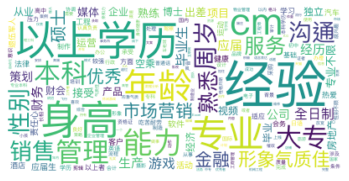

In [57]:
# include 学历 专业
generate_word_cloud(m_des_texts)

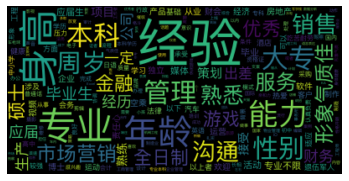

In [65]:
generate_word_cloud(m_des_texts)

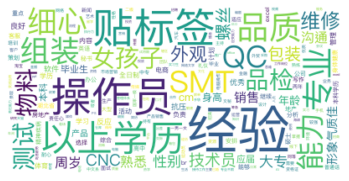

In [58]:
# include 学历 专业
generate_word_cloud(f_des_texts)

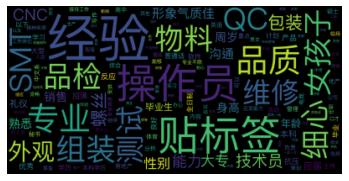

In [66]:
generate_word_cloud(f_des_texts)

In [81]:
## remove duplciate rows based on values of "company_name","descrimination_content", "job_title" columns

In [78]:
# original count: 179, after deduplicates: 163
no_dup_f_df = f_df.drop_duplicates(subset=["company_name","descrimination_content", "job_title"], ignore_index=True)

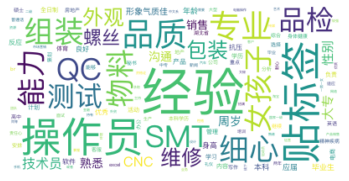

In [98]:
no_dup_f_des_res = process_descrimination_contents(no_dup_f_df, user_stop_words)
no_dup_f_des_res = sum(no_dup_f_des_res, [])
generate_word_cloud(no_dup_f_des_res)

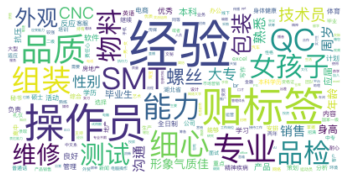

In [99]:
generate_word_cloud(no_dup_f_des_res)

In [82]:
# original count 156, after deduplicate: 153
no_dup_m_df = m_df.drop_duplicates(subset=["company_name","descrimination_content", "job_title"], ignore_index=True)

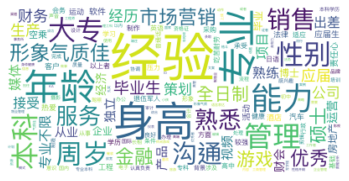

In [100]:
no_dup_m_des_res = process_descrimination_contents(no_dup_m_df, user_stop_words)
no_dup_m_des_res = sum(no_dup_m_des_res, [])
generate_word_cloud(no_dup_m_des_res)

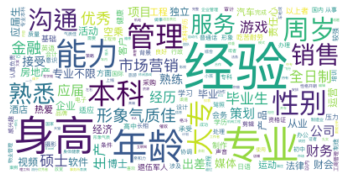

In [101]:
generate_word_cloud(no_dup_m_des_res)

In [104]:
## todo: m_df, f_df => deduplciates then do analysis?

In [116]:
m_job_type = m_df["job_type"].dropna().unique()

In [119]:
m_df["job_type"].dropna().value_counts().head(10)

销售代表     5
质量管理     4
生产经理     3
会计助理     3
会计       2
仓库管理员    2
生产管理     2
其他       2
摄影师      2
市场助理     2
Name: job_type, dtype: int64

In [123]:
m_df["keywords"].dropna().value_counts().head(10)

财务        2
销售        2
会计        2
职员        1
阿里运营      1
行政人事助理    1
采购专员      1
仓管员       1
品质管理      1
新媒体运营     1
Name: keywords, dtype: int64

In [114]:
f_job_type = f_df["job_type"].dropna().unique()

In [121]:
f_df["job_type"].dropna().value_counts().head(10)

普工       32
贸易        5
组装工       5
质量管理      5
电商专员      4
业务员       4
文员        4
业务跟单员     3
商务助理      3
品管员       3
Name: job_type, dtype: int64

In [122]:
f_df["keywords"].dropna().value_counts().head(10)

普工      29
亚马逊      8
安检员      5
外贸       2
业务跟单     2
淘宝客服     2
跟单       2
客服       2
副总经理     1
行政文员     1
Name: keywords, dtype: int64

In [202]:
## anaylize description
# todo:
# 1. consider using tf-idf => done
# 2 some jd has company address and contact info, should be removed.
# 3 deduplicate => done

In [157]:
jieba.load_userdict("./user_dict_jd_desc.txt")

In [88]:
user_stop_words = set()
with open("./user_stopwords.txt", 'r') as f:
    user_stop_words = set(f.read().splitlines()) 

In [60]:
def process_jd_contents(df, user_stop_words):
    """
    # param: df: pandas data frame columns => "job_description"
    # param: stop_words: set of customized stop words
    
    # return: [str] list of list of tokenized words
    """
    res = []
    for item in df:
        phrase = gensim.utils.tokenize('.'.join(item)) # return a generator， remove number and special characters
        for p in phrase:
            words = jieba.lcut(p)
            temp = [w for w in words if len(w)>1 and w not in user_stop_words]
        if temp:
            res.extend(temp) 
    return res

In [90]:
m_jd_tokens = process_jd_contents(m_df["job_description"], user_stop_words)

In [159]:
jieba.lcut("公司拥有强大的技术研发")

['公司', '拥有', '强大', '的', '技术研发']

In [91]:
f_jd_tokens = process_jd_contents(f_df["job_description"], user_stop_words)

In [212]:
from sklearn.feature_extraction.text import TfidfVectorizer
f_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=gensim.utils.tokenize, stop_words=user_stop_words)

In [213]:
f_tfidf = f_vectorizer.fit_transform(f_jd_tokens)

In [238]:
f_freq = {w: round(f_vectorizer.idf_[ind],2)*100 for w, ind in f_vectorizer.vocabulary_.items()}


In [33]:
def generate_jd_word_cloud(des_texts):
    """
    # param: des_texts: {word: freq}
    # return: a word cloud img
    """
    wc = wordcloud.WordCloud(font_path='./PingFang.ttc', collocations=False, background_color="white")
    wc.generate_from_frequencies(des_texts)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

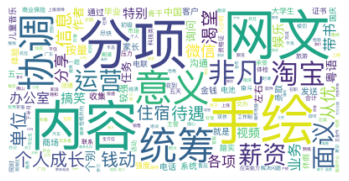

In [244]:
generate_jd_word_cloud(f_freq)

In [245]:
m_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=gensim.utils.tokenize, stop_words=user_stop_words)
m_tfidf = m_vectorizer.fit_transform(m_jd_tokens)
m_freq = {w: round(m_vectorizer.idf_[ind],2)*100 for w, ind in m_vectorizer.vocabulary_.items()}

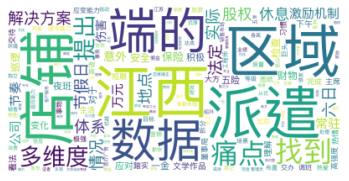

In [246]:
generate_jd_word_cloud(m_freq)

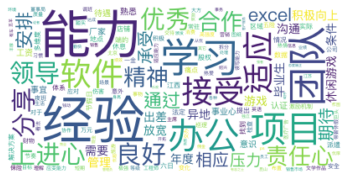

In [92]:
generate_word_cloud(m_jd_tokens)

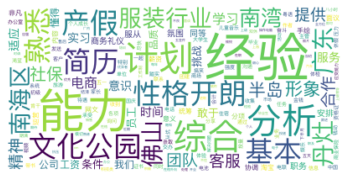

In [94]:
generate_word_cloud(f_jd_tokens)

In [ ]:
### salary difference

In [251]:
m_df.columns

Index(['url', 'company_name', 'company_size', 'company_industry',
       'company_address', 'city', 'district', 'job_title', 'job_description',
       'descrimination_content', 'salary_range', 'gender_preference',
       'salary_low', 'salary_high', 'company_size_low', 'company_size_high',
       'platform', 'company_type', 'job_type', 'keywords', 'age_requirement',
       'jd_date', 'jd_publish_month', 'province'],
      dtype='object')

In [34]:
def process_salary(f_df, m_df):
    """
    :param df: pandas dataframe, containing "salary_high", "salaray_low" two columns
    """
    def _helper(df):
        return np.append(
            df[["salary_low", "salary_high"]].dropna().mean(axis=1).values, 
            [df["salary_low"].min(), df["salary_high"].max()]
        )
    
    f_salary = pd.DataFrame(_helper(f_df), columns=["salary"])
    f_salary["gender"] = "女性"
    m_salary = pd.DataFrame(_helper(m_df), columns=["salary"])
    m_salary["gender"] = "男性"
    return f_salary.append(m_salary, ignore_index=True)

In [299]:
salary_df = process_salary(f_df, m_df)


In [312]:
def salary_jitter_chart(salary_df):
    title = "不同性别工资范围"
    ax = sns.stripplot(x="gender", y="salary", data=salary_df, jitter=0.1, palette=[female_color, male_color])
    ax.set(frame_on=False, xlabel="", ylabel="工资（月薪）") 
    ax.set_title(title, pad=25)

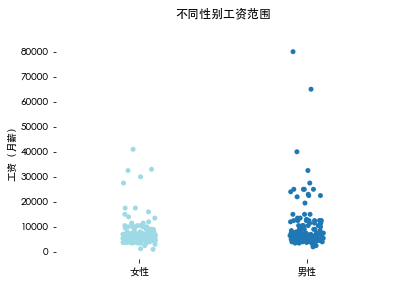

In [313]:
salary_jitter_chart(salary_df)

In [ ]:
### tokenize job_title, and compare to see if there are difference between genders

In [59]:
def process_job_title(jt_list):
    """
    :param jt_list: [str] for job title
    """
    job_title = []
    for title in jt_list:
        temp = [w for w in jieba.cut(title) 
                if len(w)>1 
                and not any(s.isdigit() for s in w)
                and w not in user_stop_words]
        job_title.extend(temp)
    return job_title

In [45]:
f_job_title = process_job_title(f_df["job_title"].tolist())

In [46]:
m_job_title = process_job_title(m_df["job_title"].tolist())

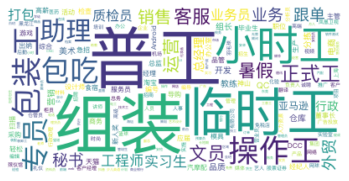

In [47]:
generate_word_cloud(f_job_title)

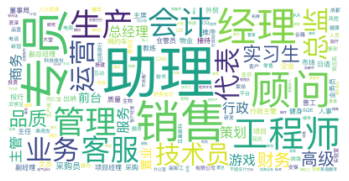

In [48]:
generate_word_cloud(m_job_title)

In [351]:
from collections import Counter

In [362]:
a = Counter(m_job_title)
a.most_common()
b = Counter(f_job_title)
b.most_common()

### different jobs for different gender in same company industry: 

In [37]:
f_job_title_elec_industry = process_job_title(f_df.loc[f_df['company_industry']=='电子技术','job_title'].tolist())


In [39]:
m_job_title_elec_industry = process_job_title(m_df.loc[m_df['company_industry']=='电子技术','job_title'].tolist())

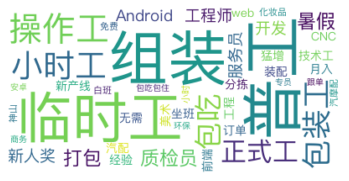

In [43]:
generate_word_cloud(f_job_title_elec_industry)

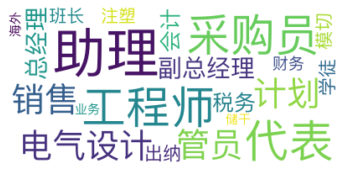

In [44]:
generate_word_cloud(m_job_title_elec_industry)

In [80]:
f_df['job_description'].str.find("产假")

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
158   NaN
159   NaN
160   NaN
161   NaN
162   NaN
Name: job_description, Length: 163, dtype: float64

In [86]:
res = []
for des in f_df['job_description']:
    for phrase in des:
        if phrase.find("产假")>=0:
            res.append(phrase)

In [87]:
res

['，享受带薪休假，享受国家规定假期（周末、年假、婚假、产假等）。',
 '福利待遇 -无责任底薪+岗位补贴+操作费+绩效奖金+节日红包+加班费+全勤奖+餐补； -试用期保底2500元，转正后平均6000-8000元，上不封顶； -缴纳法定社会保险等，完善的在职培训、良好的晋升机会； -依法享受年假、婚假、产假等带薪假； -定期安排丰富的员工活动，如旅游、生日福利、聚餐、观赏音乐会等； -工作日上班7.5小时 下午茶休息时间 月休6天 上升空间及发展前景 法务客服（银行外包）--团队组长--部门主管--地区经理',
 '4、员工享有国家法定假15天，享有工伤假、婚假、丧假、产假、带薪年休假等假期；',
 '，享受带薪休假，享受国家规定假期（周末、年假、婚假、产假等）。',
 '，享受带薪休假，享受国家规定假期（周末、年假、婚假、产假等）。',
 '※有年休假、产假、婚假等法定假日。',
 '※有年休假、产假、婚假等法定假日。']

In [85]:
'职责描述：'.find("产假")

-1